In [2]:
import matplotlib.pyplot as plt
import matplotlib as mpl
# if getting error, please mute the three lines below
mpl.rcParams.update(mpl.rcParamsDefault)
plt.rcParams.update({'text.usetex': True}) # import to make plots nicer
%config InlineBackend.figure_format = 'svg' # import to make plots nicer
import numpy as np
from scipy.optimize import fsolve, approx_fprime
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

plt.rcParams['axes.titlesize'] = 20
plt.rcParams['axes.labelsize'] = 16


# Set global font size for x and y tick labels
plt.rcParams['xtick.labelsize'] = 16
plt.rcParams['ytick.labelsize'] = 16

# Set global font size for the legend
plt.rcParams['legend.fontsize'] = 16
plt.rcParams['figure.figsize'] = (8, 6)

In [3]:
k = 1 # scaling of time
k1, k3, k2 = 9.18/k, 0.12/k, 10/k
r1, r2, r3 = 2.04/k, 9.34/k, 0.56/k
Km1, Km2, Km3, Km4 = 0.46, 9.34, 1.26, 0.18
Dt, ACt =  1.26, 10
PDEt, Et = 9.66, 2.04

def G(u, v, J, K): # equation (4)
    numerator = 2 * u * K # numerator of the fraction
    den_1 = v - u + v * J + u * K # first part of the denominator
    den_2 = -4 * (v - u) * u * K # second part of the denominator
    radicand = den_1**2 + den_2 # expression under the square root
    denominator = den_1 + np.sqrt(radicand) # compute the entire denominator
    return numerator / denominator # compute and return the fraction

def CAMP(x, param):
    cAMP, PDEp = x
    ACp = ACt*G(r1*cAMP, r2*Dt, Km1/ACt, Km2/ACt)
    dPDEp  = r3 * cAMP * ((PDEt - PDEp) / Km3) - param * Et * PDEp / (Km4 + PDEp)
    dcAMP = (k1*ACp) - (k3 + k2 * PDEp) * cAMP
    return np.array([dcAMP, dPDEp])

In [4]:
param_values = np.linspace(0.01, 6, 1000)
x0 = [0.5, 0.5] # initial conditions

epsilon = np.sqrt(np.finfo(float).eps) # small increment

# list of eq. pts, eigenvalues and parameters
equilibrium_list = []
re_part = []
im_part = []
parameter_values = []

for param in param_values:
    equilibrium = fsolve(CAMP, x0, args=(param,))
    x0 = equilibrium
    parameter_values.append(param)
    equilibrium_list.append(equilibrium)

    jacobian = np.array([approx_fprime(equilibrium, CAMP, epsilon, param)]).reshape(2, 2)
    eigenvalues = np.linalg.eigvals(jacobian)
    re_part.append(np.real(eigenvalues))
    im_part.append(np.imag(eigenvalues))

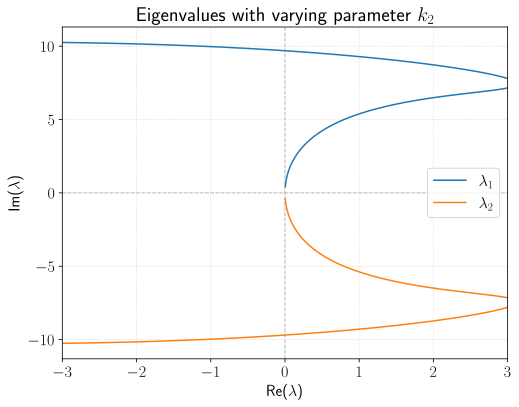

In [5]:
re_part = np.array(re_part)
im_part = np.array(im_part)
parameter_values = np.array(parameter_values)

plt.plot(re_part[:, 0], im_part[:, 0], label=r'$\lambda_1$')
plt.plot(re_part[:, 1], im_part[:, 1], label=r'$\lambda_2$')
plt.grid(True, linestyle=':', color='lightgray')
plt.axhline(0, color='grey', linewidth=1, linestyle='--', alpha=0.5)
plt.axvline(0, color='grey', linewidth=1, linestyle='--', alpha=0.5)
plt.xlabel(r'Re($\lambda$)')
plt.ylabel(r'Im($\lambda$)')
plt.title('Eigenvalues with varying parameter $r_4$')  #3, 3.3
plt.legend()
plt.xlim(-3, 3)
plt.savefig('evalues_corssing_im_axis_r4', dpi=300)
plt.show()

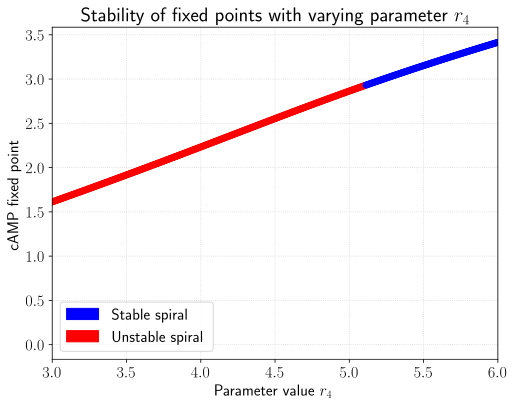

In [16]:
plt.figure()

#
camp_equlibrium = [eq[0] for eq in equilibrium_list]
equl_saddle = np.zeros(len(camp_equlibrium))

# list of real and imaginary parts of eigenvalues
real_parts_first_eigenvalue = [re[0] for re in re_part]
imag_parts_first_eigenvalue = [im[0] for im in im_part]
real_parts_second_eigenvalue = [re[1] for re in re_part]
imag_parts_second_eigenvalue = [im[1] for im in im_part]

colors = []
for (real1, imag1, real2, imag2) in zip(real_parts_first_eigenvalue, imag_parts_first_eigenvalue, real_parts_second_eigenvalue, imag_parts_second_eigenvalue):
    if (real1 < 0 and imag1 != 0) and (real2 < 0 and imag2 != 0):
        colors.append('b')  # Stable spiral
    elif (real1 > 0 and imag1 != 0) and (real2 > 0 and imag2 != 0):
        colors.append('r')  # Unstable spiral
    elif (real1 < 0 and imag2 == 0) and (real2 < 0 and imag2 == 0):
        colors.append('purple')  # Stable node
    elif (real1 > 0 and imag2 == 0) and (real2 > 0 and imag2 == 0):
        colors.append('y')  # Unstable node
    elif (real1 > 0 and imag1 != 0) and (real2 < 0 and imag2 != 0):
        colors.append('green')  # Saddle point
    else:
        colors.append('orange')  # Unknown
plt.grid(True, linestyle=':', color='lightgray', zorder=1)
plt.scatter(param_values, camp_equlibrium, c=colors, zorder=2)
#plt.scatter(param_values, equl_saddle, c='green', zorder=2)


blue_patch = mpatches.Patch(color='blue', label='Stable spiral', zorder=2)
red_patch = mpatches.Patch(color='red', label='Unstable spiral', zorder=2)
#green_patch = mpatches.Patch(color='green', label='Saddle point', zorder=2)
#purple_patch = mpatches.Patch(color='purple', label='Stable node', zorder=2)
yellow_patch = mpatches.Patch(color='y', label='Unstable node', zorder=2)
plt.legend(handles=[blue_patch, red_patch], loc='lower left')
plt.title(r'Stability of fixed points with varying parameter $r_4$')
plt.xlabel(r'Parameter value $r_4$')
plt.ylabel('cAMP fixed point')
plt.xlim(3,6)
plt.savefig('parameter_values_vs_first_component_r_4.png', dpi=300, bbox_inches='tight')
plt.show()

In [7]:
# find where eigenvalue changes sign
def find_where_eigenvalue_changes(list):
    for i in range(10,len(list)):
        if list[i-1] < 0 and list[i] >=0:
            return i
        elif list[i-1] > 0 and list[i] <=0:
            return i

    return None

print(find_where_eigenvalue_changes(re_part[:, 0]))


851


In [8]:
param_values[851]

5.112592592592593

In [9]:
re_part

array([[ 3.75586550e-03,  3.75586550e-03],
       [ 6.01750682e-03,  6.01750682e-03],
       [ 8.28638882e-03,  8.28638882e-03],
       ...,
       [-4.64226866e+00, -4.64226866e+00],
       [-4.66798443e+00, -4.66798443e+00],
       [-4.69358552e+00, -4.69358552e+00]])